In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *
import torch
import skimage
from PIL import Image

In [2]:
def es_correcta(imagen): return imagen[0] == 'B'

In [3]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='Nearest')

In [4]:
class RuidoScikit(object):
    """Clase para aplicar ruido gausiano mediante sci-kit."""
    def __init__(self,mode,seed):
        self.mode = mode
        self.seed = seed

    def __call__(self, image):
        image = np.asarray(image)
        image = skimage.util.random_noise(image, mode=self.mode , seed=self.seed)
        #image = Image.fromarray(np.uint8(image * 255)  , 'L')
        return image

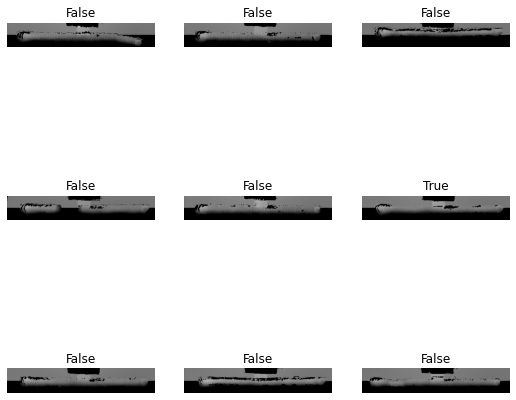

In [5]:
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# # imagen = Image.open(Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo2/Completo/BDia_1_Pieza_15_Soldadura_42.png'))

# # rotacion = Rotate(p=1., draw=180)

# # atensor = transforms.ToTensor()
# # aimagen = transforms.ToPILImage()
# # imagen = aimagen(rotacion(atensor(imagen)))
# # imagen

# path = '/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo2/Completo/'
# items = get_image_files(path)[:4]
# #print(f"items:{items}")

# imagenes = []
# for image in items:
#     imagen = Image.open(image)
#     atensor = transforms.ToTensor()
#     #display(imagen)
#     imagenes.append(atensor(imagen))
#     # imagenes.append(tensor(imagen).squeeze(1))
# #print(imagenes[1].size())

# grid = make_grid(imagenes).shape
# plt.figure(figsize = (20,2))
# plt.imshow(np.transpose(make_grid(imagenes),(1,2,0)))
# #plt.imshow(make_grid(imagenes))

# # TODO : Usar las TFMDLists de fastai para hacer una serie de tranformaciones al dataset.


# items = get_image_files(path)[:4]
# imagenes2 = []
# for i in items:
#     imagen = Image.open(i)
#     imagenes2.append(imagen)


# ruido = RuidoScikit('gaussian' , 42)
# prueba = ruido(imagenes2[0])
# #prueba = Image.fromarray(np.uint8(prueba * 255)  , 'L')
# print(type(prueba))
# display(prueba)

path = Path('/home/yani/TFG-Dataset/DatasetConIncorrectas/Tipo2/Completo')
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, bs=10, seed=42,
    label_func=es_correcta
)


# # img_list = []
# # for i in range(4):
# #     img_list.append(dls.__getitem__(i)[0])
# # show(make_grid(img_list))
dls.show_batch()

## Diferencias ente fit_one_cycle() y fine_tune()

**fine_tune** allows training just the head (final layer(s)) initially, then then all layers as a second step. And that **fit_one_cycle** uses the 1cycle policy (min and max learning rates)
A continuación probamos a usar fit_one_cycle aqui en lugar de fine tune con varias epochs para comprobar si podemos crear una grafica correcta.




In [7]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
#learn.fine_tune(1)
#learn.fit_one_cycle(3)


SuggestedLRs(lr_min=0.014454397559165954, lr_steep=7.585775847473997e-07)

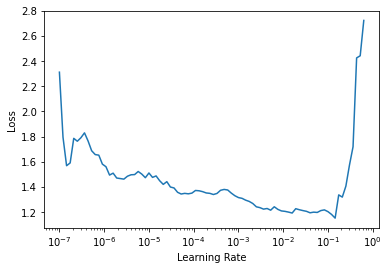

In [8]:
learn.lr_find()

In [9]:
learn.fit(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.241152,0.113610,0.961165,00:47
1,0.073002,0.033969,0.989213,00:49
2,0.064149,0.038624,0.989213,00:50
3,0.074076,0.053486,0.979504,00:48
4,0.033828,0.011983,0.995685,00:48


Obtenemos la gráfica de los valores de accuracy que hemos obtenido durante el entrenamiento. Hay 5 valores para las 5 epochs por tanto obtenemos 5 puntos en la gráfica.

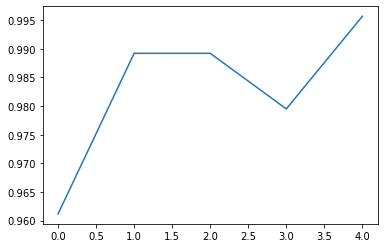

In [10]:
plt.plot(L(learn.recorder.values).itemgot(2))

In [11]:
learn.cbs

(#3) [TrainEvalCallback,Recorder,ProgressCallback]

In [12]:
learn.recorder.values

[(#3) [0.24115240573883057,0.11360996216535568,0.9611650705337524],
 (#3) [0.07300151139497757,0.03396878391504288,0.9892125129699707],
 (#3) [0.06414894014596939,0.03862444683909416,0.9892125129699707],
 (#3) [0.07407614588737488,0.05348610505461693,0.9795037508010864],
 (#3) [0.03382841497659683,0.011983462609350681,0.9956849813461304]]

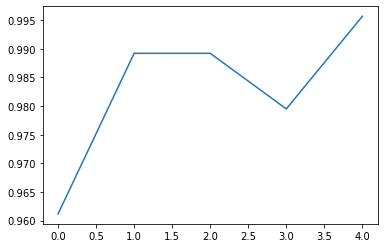

In [13]:
plt.plot(L(learn.recorder.values).itemgot(2))

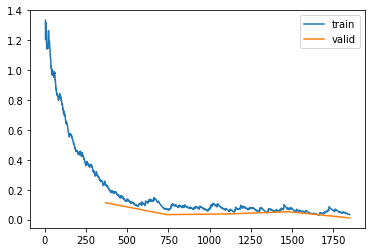

In [14]:
learn.recorder.plot_loss()

In [21]:
print(learn.metrics[0].value)

TensorBase(0.9957)


In [22]:
from fastai.imports import *
from fastai.torch_core import *
from fastai.learner import *
    
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

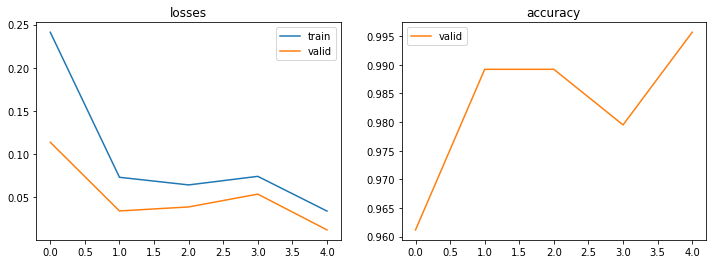

In [23]:
learn.recorder.plot_metrics()

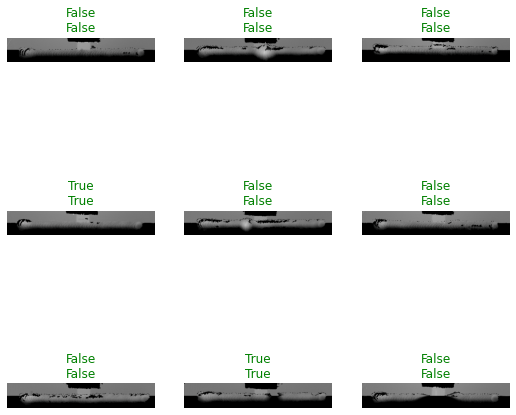

In [24]:
learn.show_results()

learn.fit_one_cycle(2, slice(5e-3,5e-2),cbs=[ShowGraphCallback()]) 

learn.show_results()

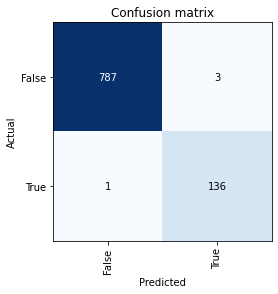

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Como vemos en la matriz de confusión se clasifican mas correctas como incorrectas que al revés.

### A continuacion pruebas sobre class activation maps (CAM).
It uses the output of the last convolu‐
tional layer (just before the average pooling layer) together with the predictions to
give us a heatmap visualization of why the model made its decision. This is a useful
tool for interpretation.
More precisely, at each position of our final convolutional layer, we have as many fil‐
ters as in the last linear layer. We can therefore compute the dot product of those acti‐
vations with the final weights to get, for each location on our feature map, the score of
the feature that was used to make a decision.

Para este proceso vamos a necesitar **hooks** que nos permiten inyectar codigo en los calculos de los niveles anteriores y posteriores.



In [27]:
img = PILImage.create('/home/yani/TFG-Dataset/DatasetConIncorrectas/'
                +'Tipo2/Completo/BDia_1_Pieza_15_Soldadura_42.png')

x, = first(dls.test_dl([img]))

Vamos a guardar las activaciones del último nivel convolucional para aplicarlo sobre la imagen que hemos seleccionado para poder ver las ***features*** que se usan para tomar la decision de si la imagen es correcta o incorrecta.

In [28]:
class Hook():
    def hook_func(self, m, i, o): self.stored = o.detach().clone()

In [29]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)

In [30]:
with torch.no_grad(): output = learn.model.eval()(x)

In [31]:
act = hook_output.stored[0]
salida = F.softmax(output, dim=-1)

In [32]:
dls.vocab

[False, True]

Predecimos con un {{salida[0][1].item()}} % que la imagen es correcta y un {{salida[0][0].item()}}% que es correcta.Con ` F.softmax(output, dim=-1)` comprobamos el resultado que da nuestro modelo para esta imagen en particular.

In [33]:
x.shape

torch.Size([1, 3, 80, 480])

In [34]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([2, 3, 15])

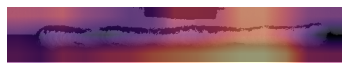

In [35]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6, extent=(0,480,80,0),
interpolation='bilinear', cmap='magma');

Como vemos en `cam_map.shape` obtenemos un tensor de tamaños `torch.Size([2, 3, 15])` que nos indica que tenemos un *feature map* de 3x15. 

A continuación aplicamos varios kernels a la imagen de la que hemos obtenido el class activation map para poder ver como el modelo aprende cuales son los ***features*** que va a tener que detectar posteriormente cuando se enfrente al validation set.

torch.Size([3, 3])


<AxesSubplot:>

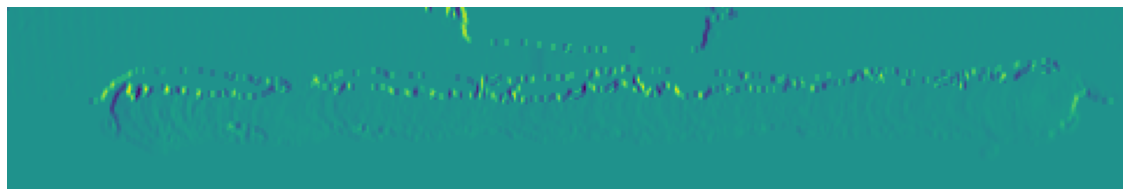

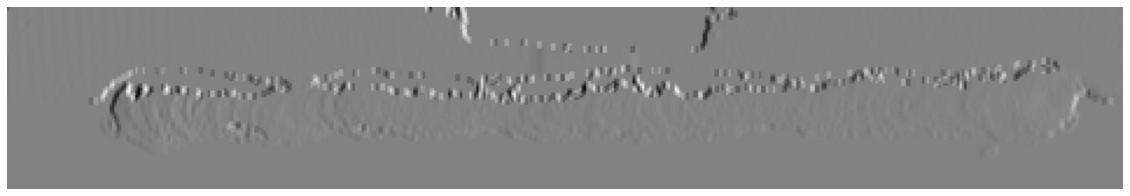

In [36]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()


bottom_edge = tensor([[ 1, 1, 1],
                      [ 0, 0, 0],
                      [-1,-1,-1]]).float()    

# imagen_prueba = tensor(image)
imagen_prueba2 = tensor(img)

# imagen_prueba3 = tensor(image3)


def apply_kernel(row, col, kernel):
    return (imagen_prueba2[row-1:row+2,col-1:col+2] * kernel).sum()

# print(imagen_prueba.size())
print(bottom_edge.size())
rng_y = range(1,79)
rng_x = range(1,479)
# rng_y = range(1,49)
# rng_x = range(1,99)
bottom_edge_imagen = tensor([[apply_kernel(i,j,bottom_edge) for j in rng_x] for i in rng_y])
top_edge_imagen = tensor([[apply_kernel(i,j,top_edge) for j in rng_x] for i in rng_y])
show_image(bottom_edge_imagen , figsize = [20 , 120] ,)
show_image(top_edge_imagen , figsize = [20 , 120] , cmap = 'binary')


A continuacion añadimos algunos experimentos con otras arquitecturas.